# 0. Réglages Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pyod

In [0]:
!pip install suod 

In [0]:
%cd /content/drive/My\ Drive/TAA

/content/drive/My Drive/TAA


In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from scipy import stats
import scipy.io

In [0]:
from sklearn.svm import OneClassSVM
import time
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.hbos import HBOS
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix

In [0]:
from evaluate import plot_var_in_out, evaluation_detection, deep_predict, evaluate
from preprocessing import upload_data, split_data, prepro_data, simul_gaussian_data, simul_uniform_data
from train_test import CustomAutoencoder, AlgoTrainPredict

# 1. Statistique descriptive

Base satimage
Proportion d'anomalies :  0.0122350508357746


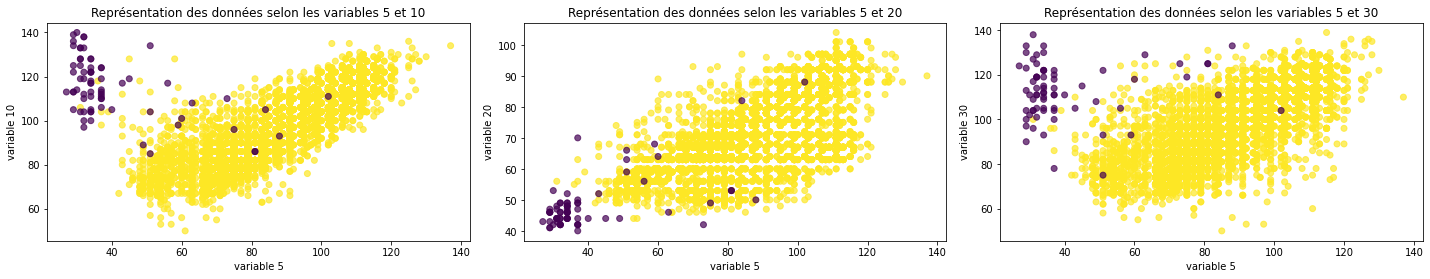

In [0]:
print("Base satimage")
X, y = upload_data('satimage-2.mat')
print("Proportion d'anomalies : ",np.sum(y==-1)/len(y))
plot_var_in_out(X,y,5,10,20,30)

Base speech
Proportion d'anomalies :  0.016549104720564298


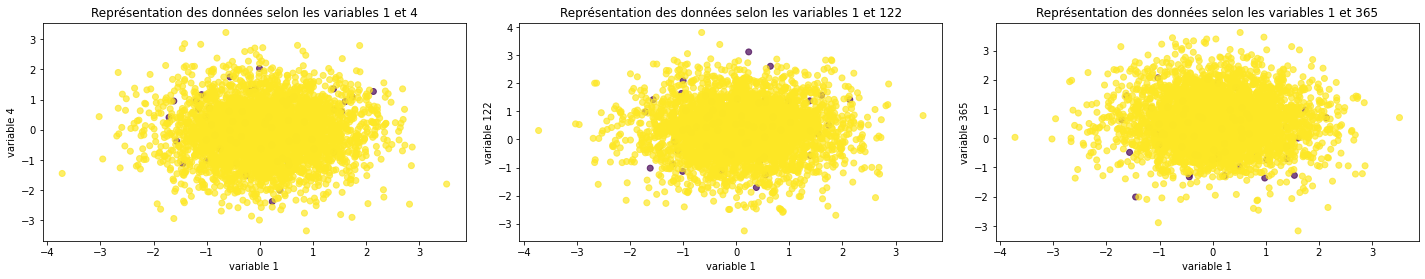

In [0]:
print("Base speech")
X_speech, y_speech = upload_data('speech.mat')
print("Proportion d'anomalies : ",np.sum(y_speech==-1)/len(y_speech))
plot_var_in_out(X_speech,y_speech,1,4,122,365)

Données simulées avec anomalies gaussiennes
Proportion d'anomalies :  0.014778325123152709


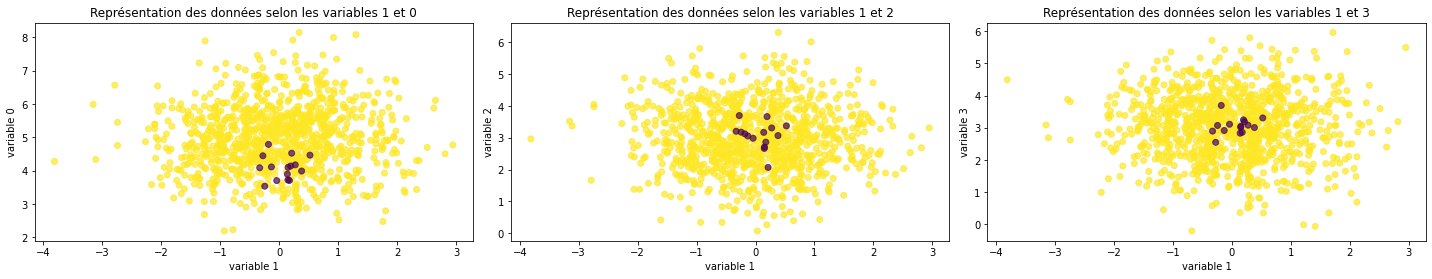

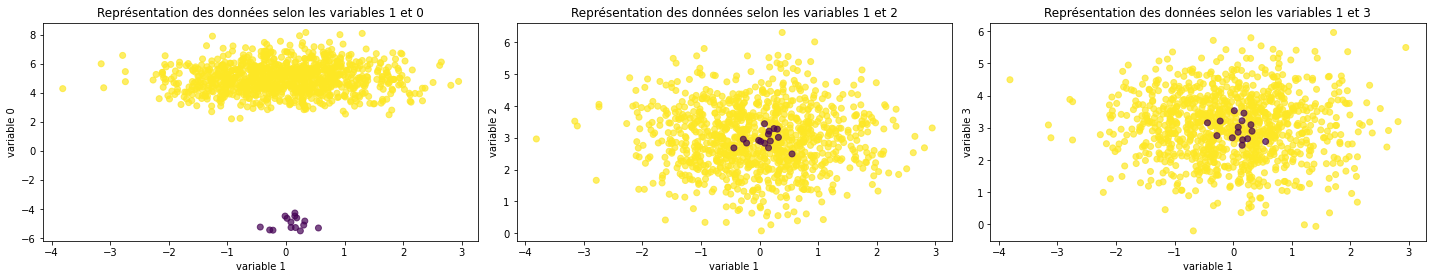

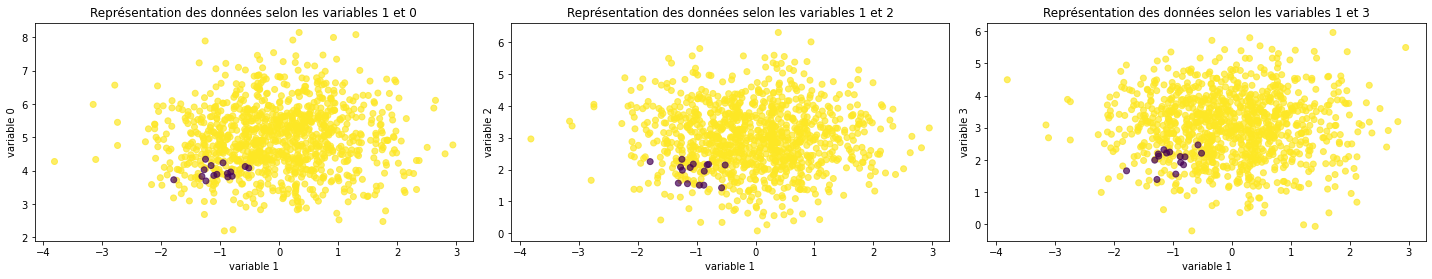

In [0]:
# Anomalies gaussiennes et données "normales"
nb_inlier,nb_outlier = 1000, 15
nb_var = 1000
X_normal, mean_normal, gaussian_anomaly_list = simul_gaussian_data(nb_var,nb_outlier, nb_inlier)

print("Données simulées avec anomalies gaussiennes")
print("Proportion d'anomalies : ",nb_outlier/(nb_inlier+nb_outlier))

for index in range(len(gaussian_anomaly_list)):
    X = np.concatenate([X_normal, gaussian_anomaly_list[index]])
    y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])
    plot_var_in_out(X,y,1,0,2,3)

Simulation d'anomalies uniformes
Proportion d'anomalies :  0.014778325123152709


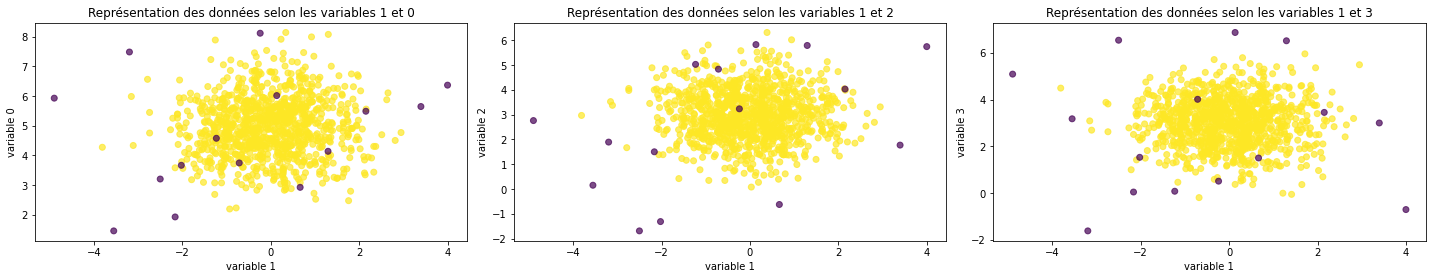

In [0]:
# Anomalies uniformes
print("Simulation d'anomalies uniformes")
print("Proportion d'anomalies : ",nb_outlier/(nb_inlier+nb_outlier))

uniform_anomaly = simul_uniform_data(nb_var,nb_outlier,mean_normal)
X = np.concatenate([X_normal,uniform_anomaly])
y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])
plot_var_in_out(X,y,1,0,2,3)

# 2. Détection d'anomalies

### 2.0 Configuration

In [0]:
config={"nb_epoch" : 200,
       "batch_size" : 50,
       "outlier_prop" : 0.03}

In [0]:
# Definition de la proportion d'anomalies 
outlier_prop = config["outlier_prop"]

### 2.1 Cas de Simulation

In [0]:
# Definition de l'autoencoder
input_dim = nb_var
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                10010     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              1100

In [0]:
anomaly_algorithms_simul = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["KNN","Local Outlier Factor","Deep MLP","Robust covariance"]

##### Simulations d'anomalies gaussiennes

%%%%%%%%%%%%%%%%%% index =  0


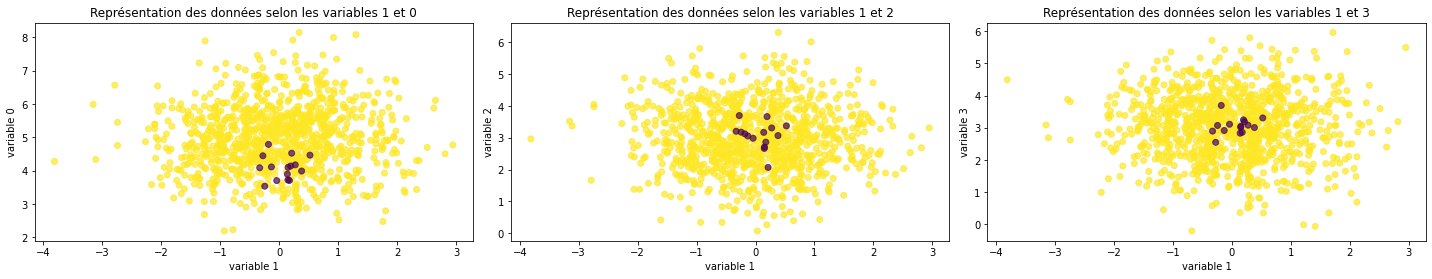

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


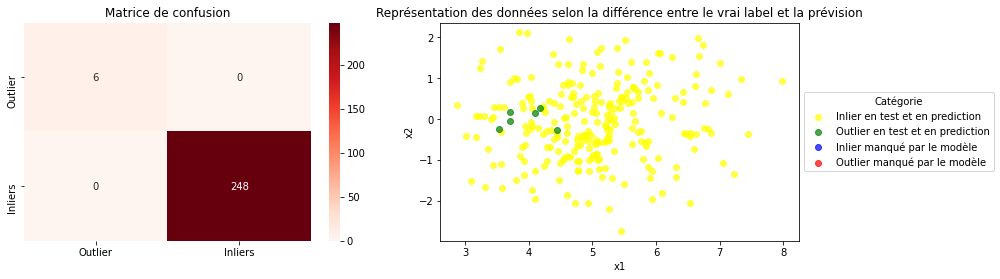

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.858268  0.439516            0.120968              0.026786


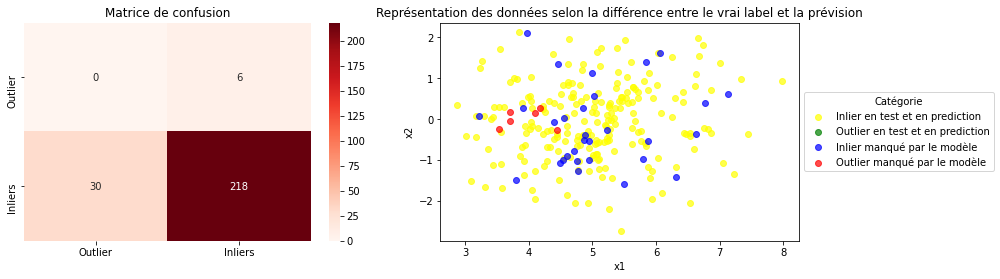

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


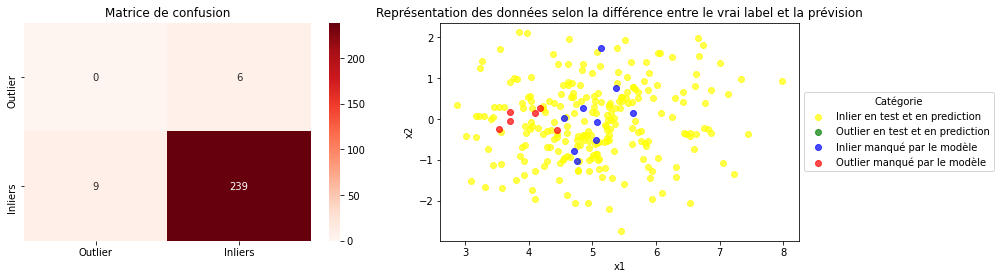

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


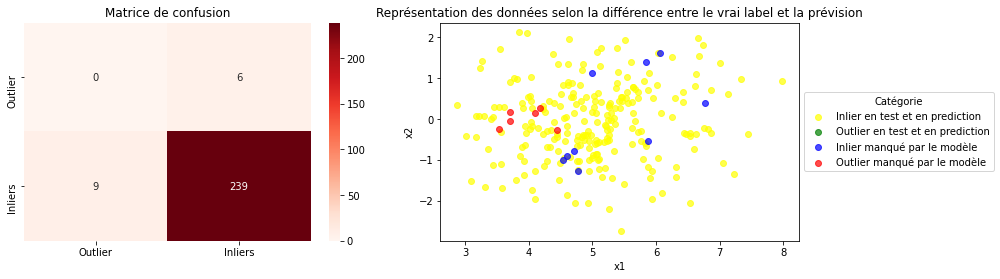

TypeError: ignored

In [0]:
for index in range(len(gaussian_anomaly_list)):
    print("%%%%%%%%%%%%%%%%%% index = ",index)
    X = np.concatenate([X_normal,gaussian_anomaly_list[index]])
    y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])

    plot_var_in_out(X,y,1,0,2,3)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    for name, algorithm in anomaly_algorithms_simul:
        AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

In [0]:
##### Simulations d'anomalies uniformes

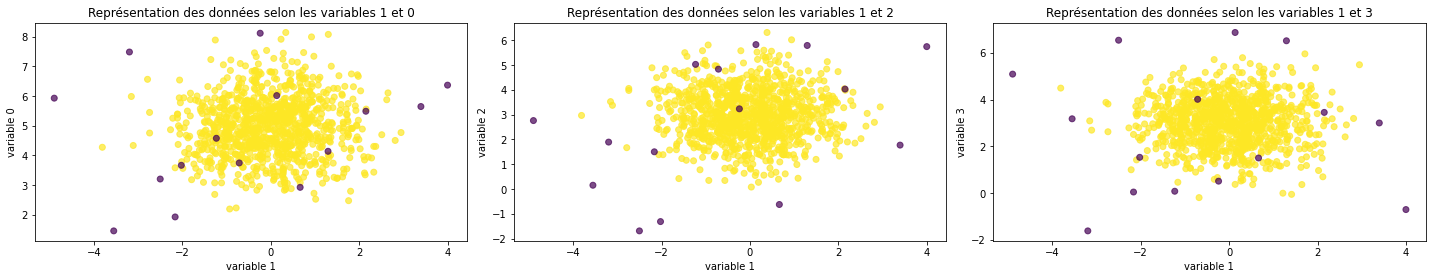

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.976378     0.5                 0.0              0.023622


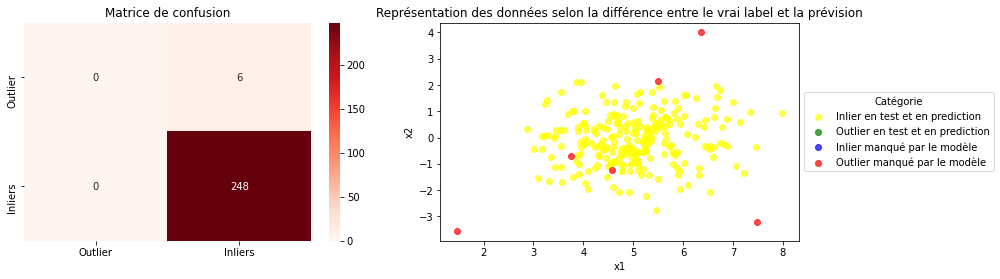

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.885827  0.941532            0.116935                   0.0


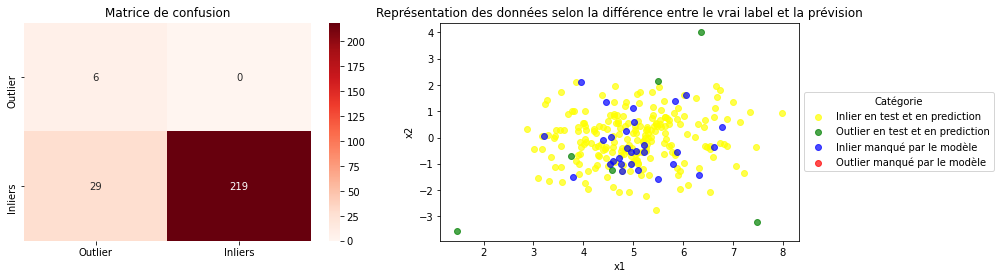

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.980315  0.989919            0.020161                   0.0


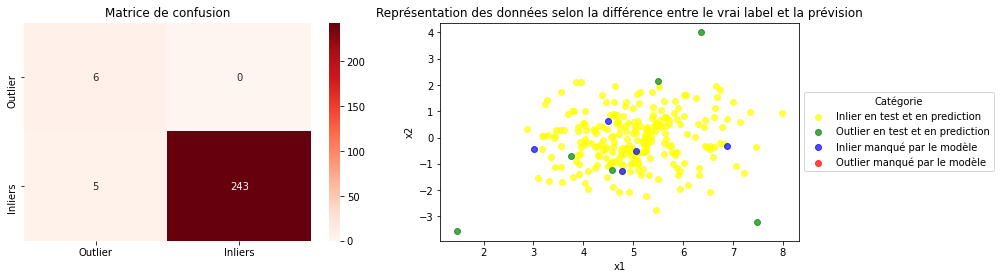

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.988189  0.993952            0.012097                   0.0


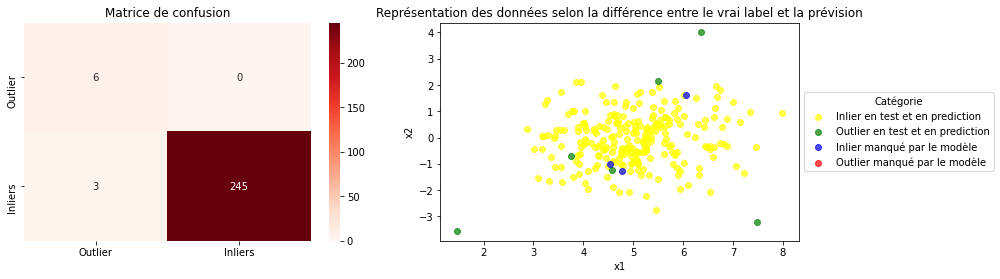

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


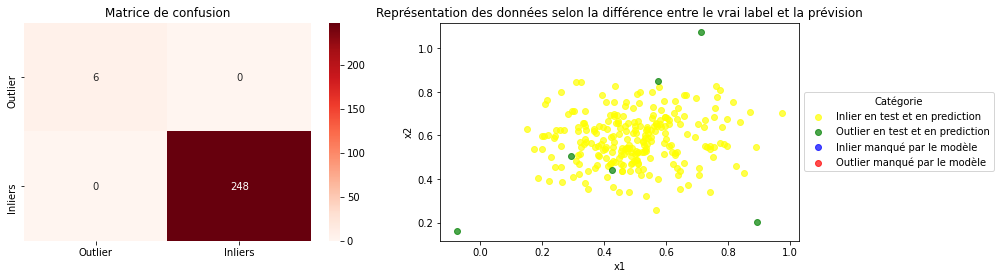

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.992126  0.995968            0.008065                   0.0


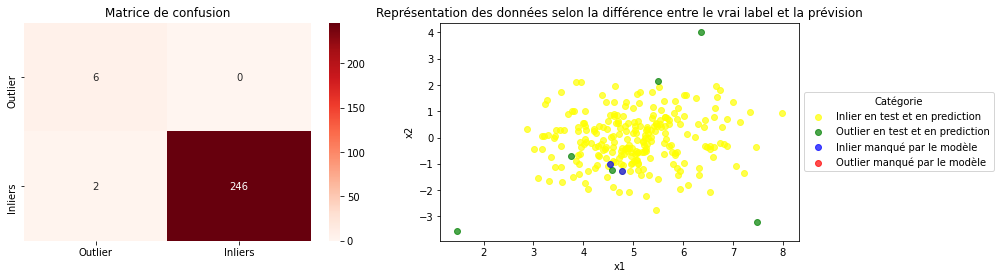

In [62]:
X = np.concatenate([X_normal,uniform_anomaly])
y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])

plot_var_in_out(X,y,1,0,2,3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

for name, algorithm in anomaly_algorithms_simul:
    AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

### 2.2 Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('satimage-2.mat', 'anomalies')

In [0]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                370       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_6 (Dense)              (None, 36)                396 

In [0]:
anomaly_algorithms_satimage = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.968987  0.780868            0.026499              0.004989


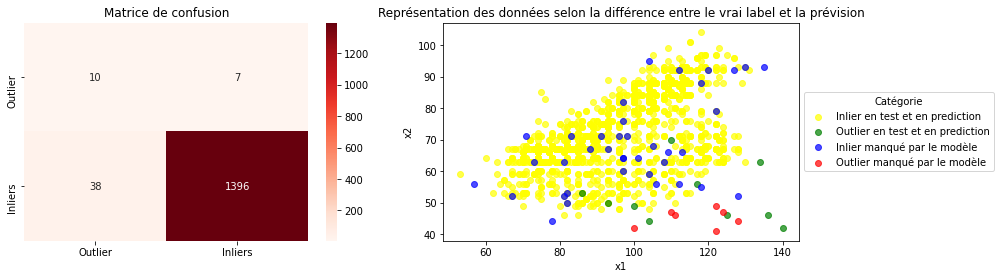

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.973811  0.841435            0.023013              0.003556


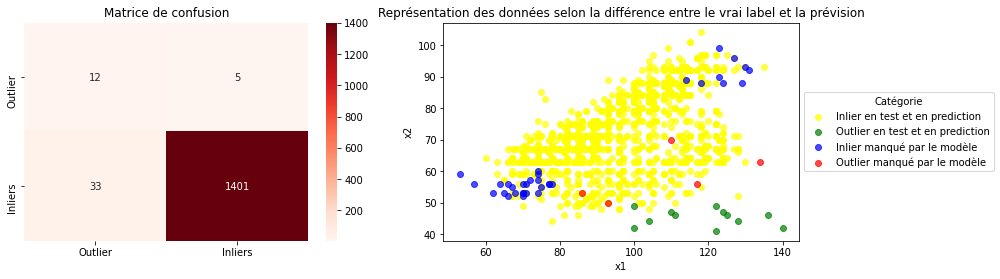

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.971744  0.869452            0.025802              0.002855


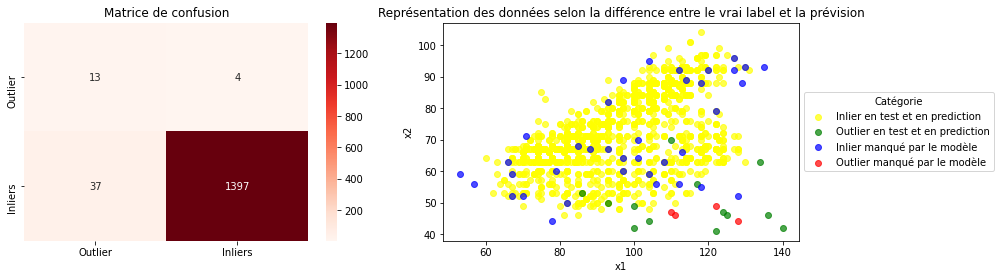

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978635  0.989191            0.021618                   0.0


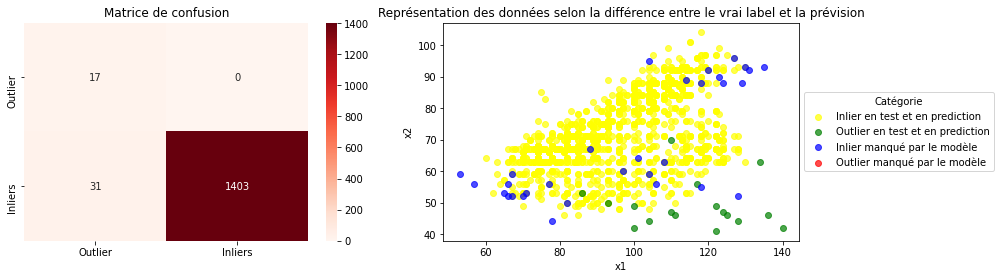

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.977257  0.988494            0.023013                   0.0


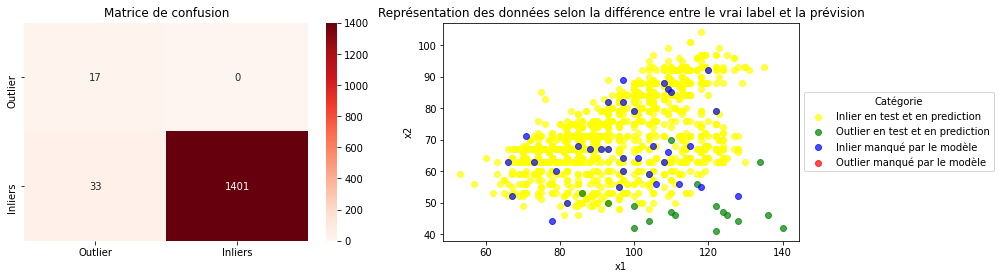

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.023432  0.505927            0.988145                   0.0


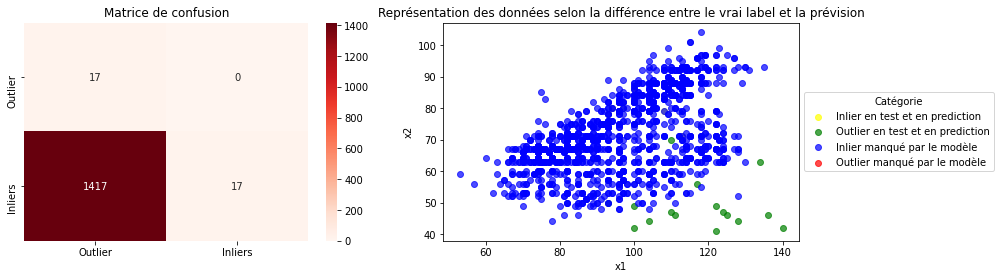

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.960717  0.544179            0.029289              0.010661


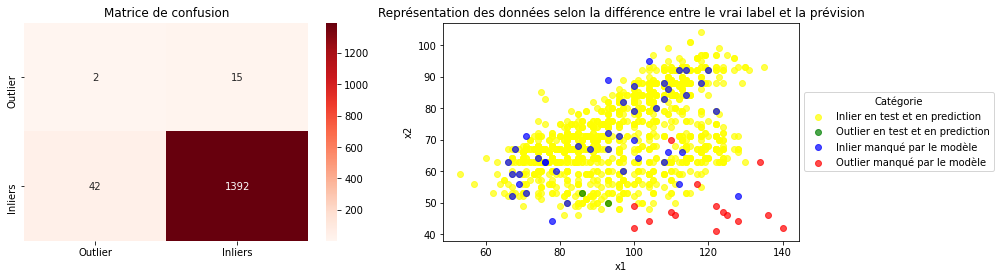

In [0]:
for name, algorithm in anomaly_algorithms_satimage:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled,outlier_prop,y_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)

### 2.3 Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('speech.mat', 'anomalies')

In [0]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                4010      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 400)               4400

In [0]:
anomaly_algorithms_speech = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.563997              0.0299              0.017937


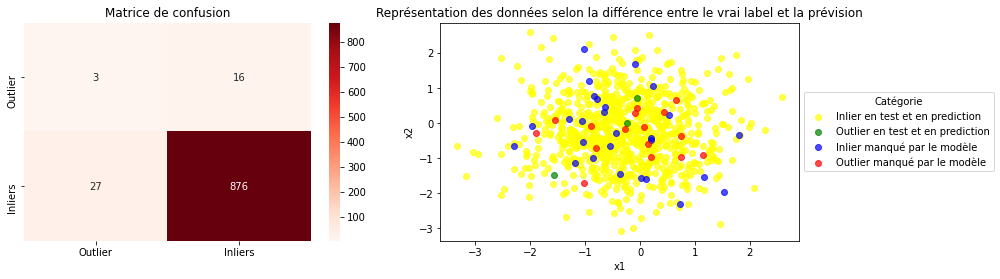

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.950108  0.510812            0.031008              0.020157


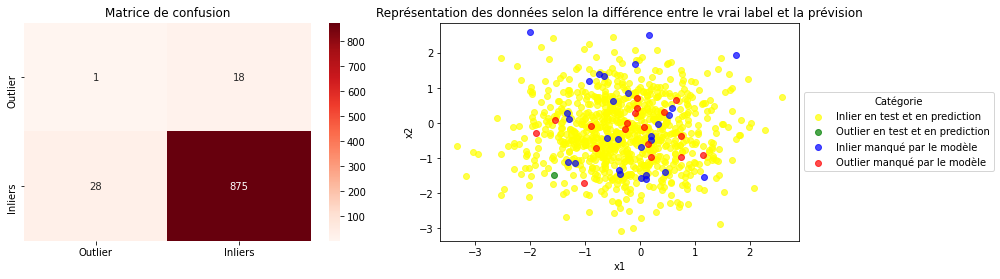

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.951193  0.537128            0.031008              0.019058


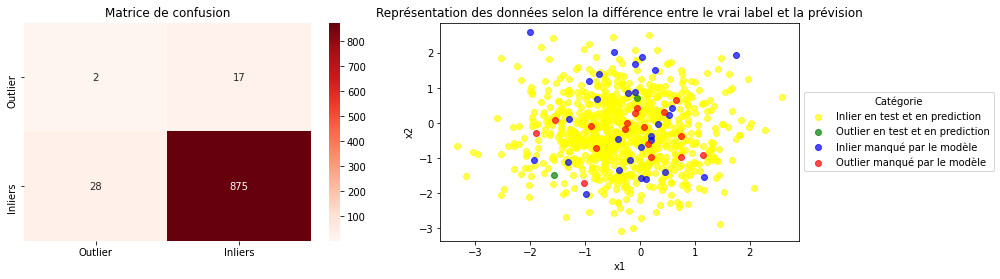

---------Isolation Forest-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


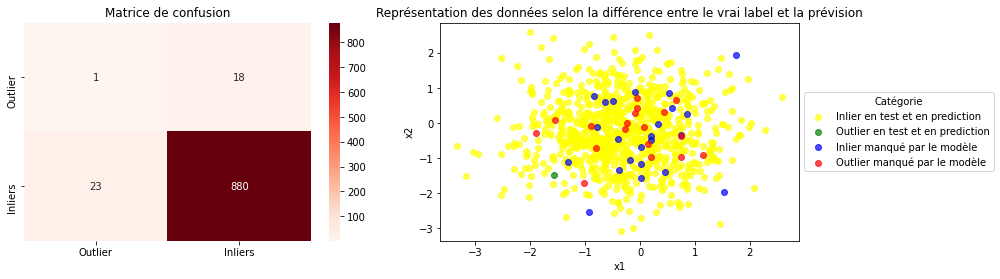

---------KNN-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


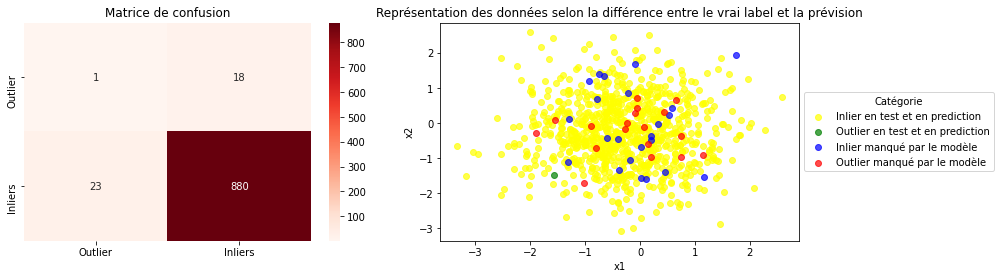

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.020607     0.5                 1.0                   NaN


/content/drive/My Drive/TAA/evaluate.py:132: RuntimeWarning: invalid value encountered in long_scalars
  metrics['False discovery rate'] = [FP/(TP+FP)]


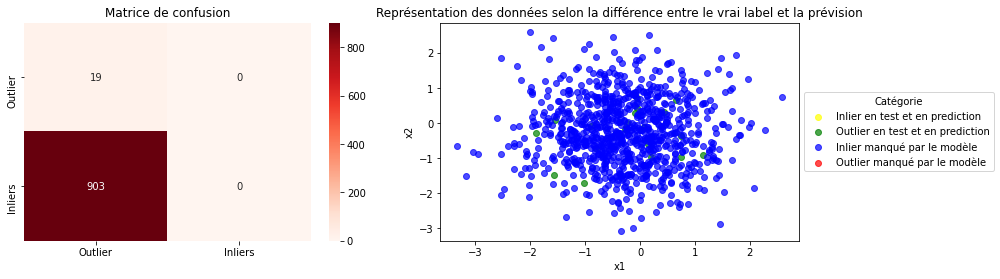

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.538235            0.028793              0.019016


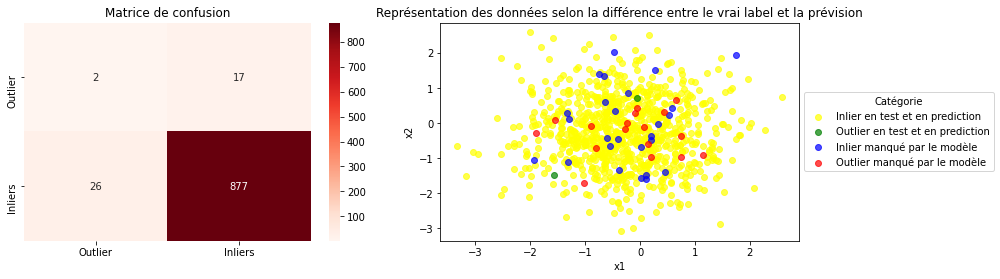

In [0]:
for name, algorithm in anomaly_algorithms_speech:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled,outlier_prop,y_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)

# 3. Détection de nouveautés

### 3.1 Cas de Simulation

### 3.2 Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('satimage-2.mat', 'nouveautes')

In [0]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_17 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_18 (Dense)             (None, 36)                396 

In [0]:
novelty_algorithms_satimage = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=15, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.970443  0.977701            0.030514              0.000898


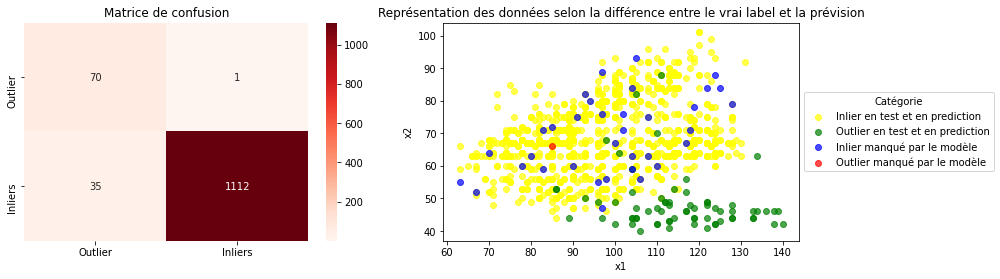

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.982759  0.918176            0.008718              0.009582


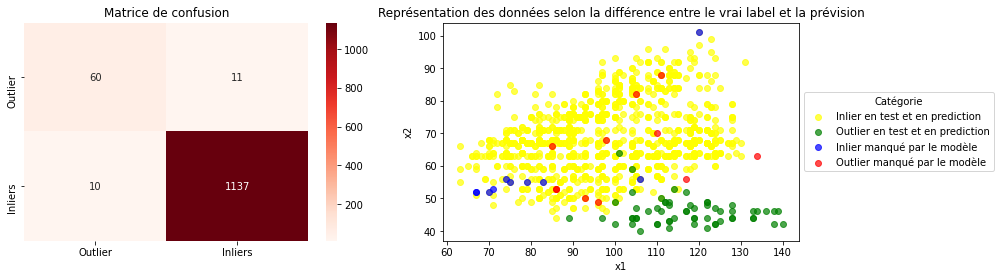

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.971966            0.027899              0.001791


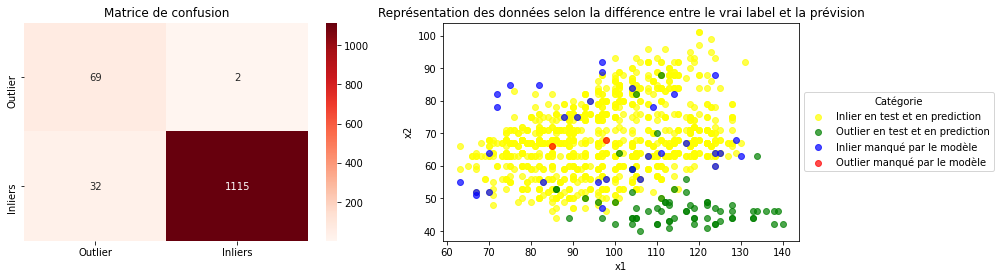

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978654  0.975453            0.020924              0.001778


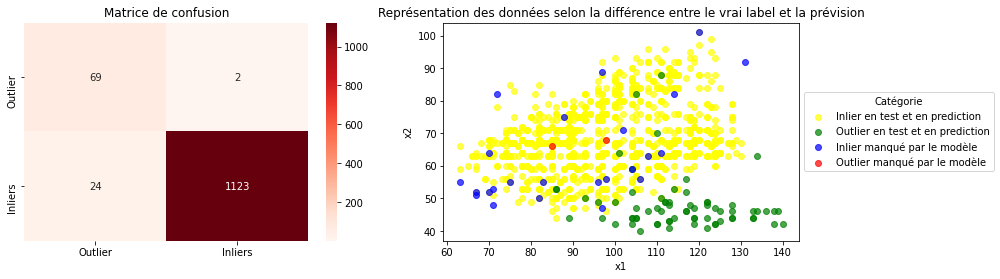

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.985179            0.029643                   0.0


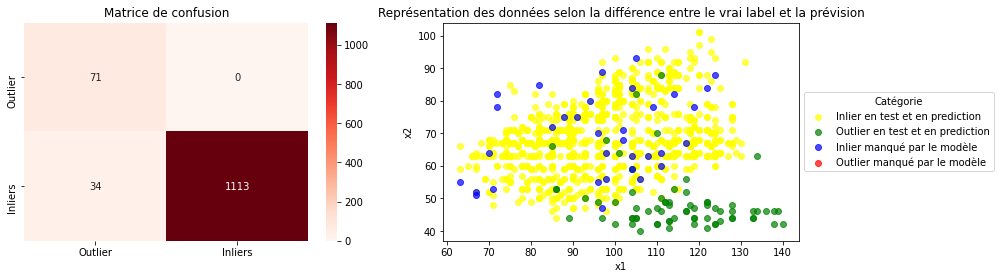

---------Deep MLP-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.076355  0.50959             0.98082                   0.0


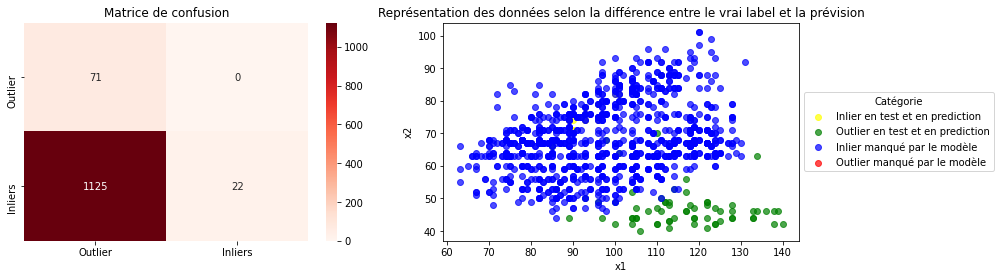

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.924466  0.543696            0.025283              0.053345


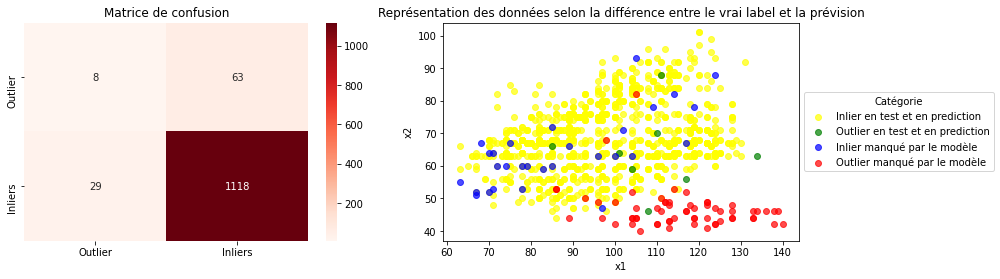

In [0]:
 for name, algorithm in novelty_algorithms_satimage:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled,outlier_prop,y_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)

### 3.3 Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data('speech.mat', 'nouveautes')

In [0]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                4010      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_23 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_24 (Dense)             (None, 400)               4400

In [0]:
novelty_algorithms_speech = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.890585  0.550322            0.046897              0.069987


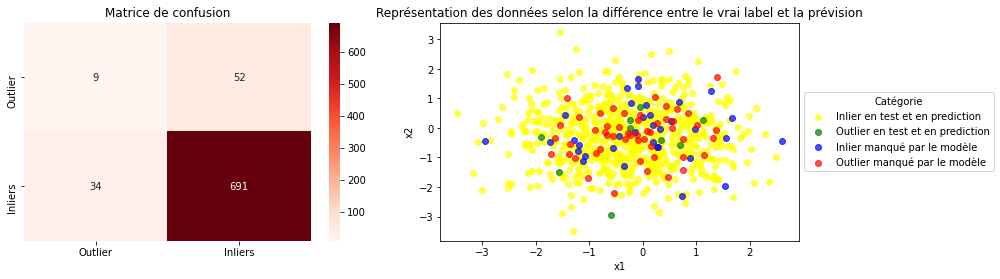

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.784987  0.463053            0.155862              0.083832


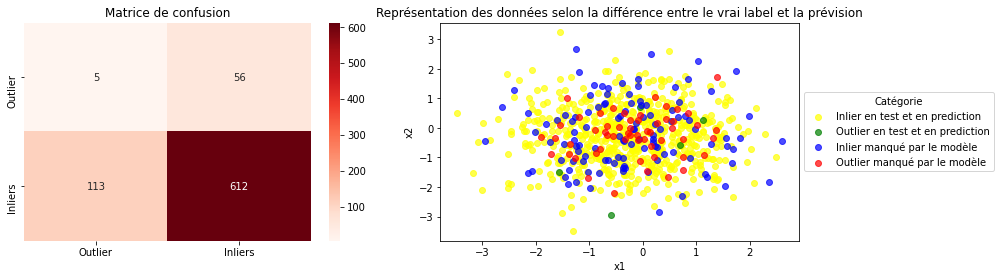

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.776081  0.465732            0.166897               0.08346


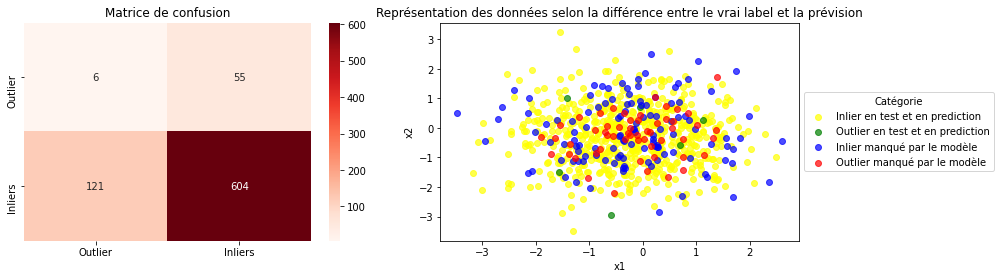

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.795165  0.476077            0.146207              0.081602


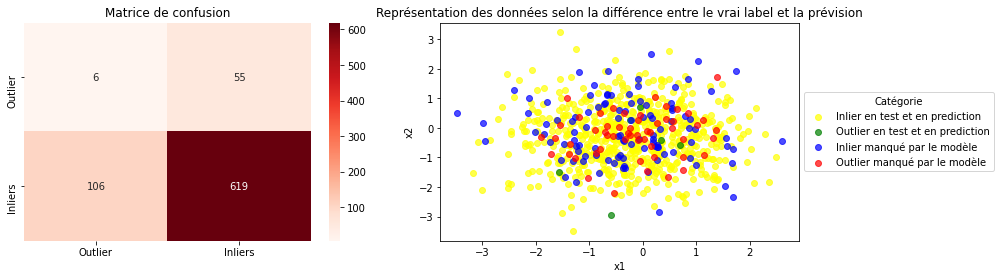

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0   0.78626  0.471249            0.155862              0.082459


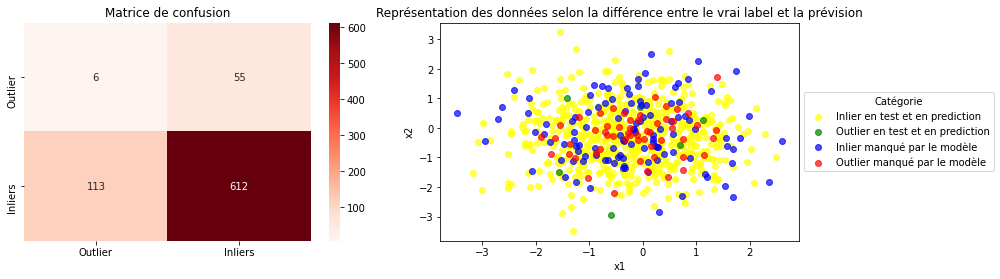

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.077608     0.5                 1.0                   NaN


/content/drive/My Drive/TAA/evaluate.py:132: RuntimeWarning: invalid value encountered in long_scalars
  metrics['False discovery rate'] = [FP/(TP+FP)]


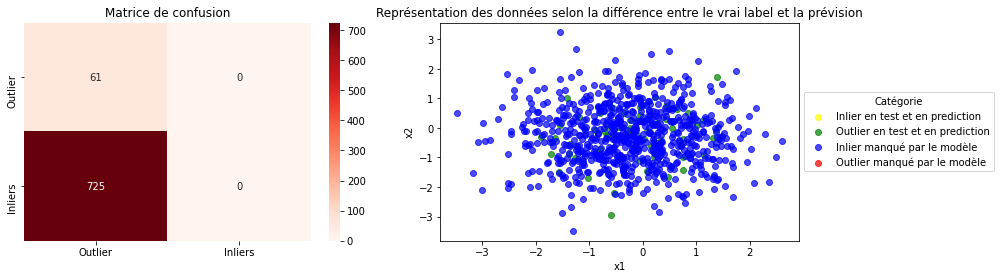

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.894402  0.492335            0.031724               0.07874


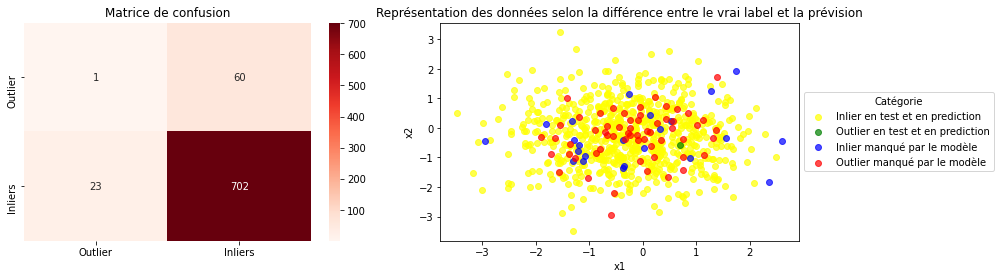

In [0]:
for name, algorithm in novelty_algorithms_speech:
   if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Local Outlier Factor":
     algorithm.fit(X_train)
     y_pred = algorithm.fit_predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name == "Deep MLP":
     algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
     y_pred = deep_predict(algorithm,X_test_scaled,outlier_prop,y_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)
   if name not in algo_particuliers:
     algorithm.fit(X_train)
     y_pred = algorithm.predict(X_test)
     print('---------'+name+'-----------')
     print(evaluate(y_test,y_pred))
     evaluation_detection(X_test,y_test,y_pred)